In [1]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
from library.experiments import *
import matplotlib.animation as animation
%matplotlib notebook
SEED = 1231

In [2]:
def do_multiple_exps(obj, opt, zoneParas):
    np.random.seed(SEED)
    
    # init multiple experiments
    mexps = multiple_experiment()

    # init one experiment
    exp = single_experiment()
    
    # One experiment: setup objective function and optimiser
    exp.set_objective(obj)
    exp.set_optimizer(opt)

    # Multiple experiment: setup one expreiment
    mexps.set_single_exp(exp)
    # Multiple experiment: setup sample zone    
    mexps.set_sample_zone(zoneParas)
    
    data = mexps.do()
    
    return data

In [3]:
class post_analysis_single():
    def __init__(self, stats):
        self.stats = stats
        self.optimal = stats['optimal']
        self.optimum = stats['optimum']
    def print_mean_variance(self):
        # print mean and variance of each iteration
        for i, a in enumerate(self.stats['std']):
            print('iter=',i, 'mean=', self.stats['mean'][i].T , '\nvar=\n', a@a.T, '\n')

    def print_evaluations_per_iteration(self):
        for i, iter_ in enumerate(self.stats['evals_per_iter']):
            print('iter=', i, '\n', iter_.squeeze(),'\n') 

    def print_points_before_and_after_adjust(self):
        for i, iter_ in enumerate(self. stats['x_adjust']):
            print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 

    def __cal_distance(self):
        self.distance_arg = np.linalg.norm(self.stats['arg'] - self.stats['optimal'].reshape(1,1,2), axis=2).mean(axis=1)
        self.distance_val = self.stats['val'].mean(axis=1)
            
    def plot_distance(self):
        self.__cal_distance()
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1, 1, 1)
        self.__plot_distance_common(ax1, self.stats['val'].shape[0]-1)
    
    def plot_moving_cluster(self):
        fig = plt.figure(figsize=(9, 9))
        row = col = 3
        unit = self.stats['val'].shape[0]/(row * col)
        for i in range(row):
            for j in range(col):
                ax=fig.add_subplot(row, col, 1 + row * i + j)
                # draw x-axis and y-axis
                ax.axvline(c='grey', lw=1)
                ax.axhline(c='grey', lw=1)
                # draw the position of optimal 
                ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
                ax.scatter(x=self.stats['arg'][int(unit * (row * i + j)),:,0], y=self.stats['arg'][int(unit * (row * i + j)),:,1], 
                           c=self.stats['val'][int(unit * (row * i + j))], vmin = 0, vmax = 10)
                # unify the x,y scope
                min_x = np.min(self.stats['arg'][:,:,0])
                min_y = np.min(self.stats['arg'][:,:,1])
                max_x = np.max(self.stats['arg'][:,:,0])
                max_y = np.max(self.stats['arg'][:,:,1])
                ax.set_xlim(min_x, max_x)
                ax.set_ylim(min_x, max_y)
                ax.set_title("%d / %d"%(int(unit * (row * i + j)), self.stats['arg'].shape[0]))

    def __plot_distance_common(self, ax1, i):
        ax1.plot(np.arange(i), self.distance_arg[1:i+1], color='green', label='Frobenius norm \nof parameters')
        ax1.set_xlim(0, self.stats['val'].shape[0])
        ax1.set_ylim(np.min(self.distance_arg)*0.9, np.max(self.distance_arg)*1.1)
        ax1.set_xlabel('iteration', fontsize=15)
        ax1.set_ylabel('distance in domain', color='green', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()  
        ax2.plot(np.arange(i), self.distance_val[1:i+1], color='red', label='L2 norm \nof func value')
        ax2.set_ylim(np.min(self.distance_val)*0.9, np.max(self.distance_val)*1.1)
        ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right') 
        
    def __draw_ellipse(self, ax, mean, std):
        eigVal_sqrt = np.linalg.norm(std, ord=2, axis=(0))
        eigVec = std / eigVal_sqrt
        width, height = 2 * 3 * eigVal_sqrt
        angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
        e1 = patches.Ellipse(mean, width, height,
                             angle=-angle, linewidth=2, fill=False, zorder=2)
        ax.add_patch(e1)
        ax.scatter(mean[0], mean[1], c='black', s=15)

    def __setup_scatter(self, ax, i):
        '''
        set up the plot of CMA-ES candidates at i-th iteration
        '''
        # draw x-axis and y-axis
        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)
        # draw the position of optimal 
        ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
        # draw the trail of local minimum
        if 'trail' in self.stats.keys():
            ax.scatter(self.stats['trail'][0], self.stats['trail'][1], c='red', s=11)
        # draw candidates on scatter plot
        min_x = np.min(self.stats['arg'][:,:,0])
        min_y = np.min(self.stats['arg'][:,:,1])
        max_x = np.max(self.stats['arg'][:,:,0])
        max_y = np.max(self.stats['arg'][:,:,1])
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_x, max_y)
        p = sns.scatterplot(x=self.stats['arg'][i,:,0], y=self.stats['arg'][i,:,1], color="r", hue=i, hue_norm=(0, self.stats['val'].shape[0]), legend=False)
        # draw ellipse representing 3 sigma areas of normal distribution
        self.__draw_ellipse(ax, self.stats['mean'][i], self.stats['std'][i])

    def animate_moving_cluster(self):
        def animate(i):
            plt.clf()
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('iter=%d' % (i+1))
            self.__setup_scatter(ax, i+1)
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['arg'].shape[0]-1, repeat=False, interval=500)
        return ani

    def animate_scatterplot_distance(self):
        def animate(i):
            plt.clf()
            # draw scatter and ellipse
            ax0 = fig.add_subplot(2, 1, 1)
            ax0.set_title('iter=%d, func_dist=%.3f,  arg_dist=%.3f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                        self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
            self.__setup_scatter(ax0, i+1)
            
            # plot distance
            ax1 = fig.add_subplot(2, 1, 2)
            self.__plot_distance_common(ax1, i+1)
        self.__cal_distance()
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['val'].shape[0]-1, repeat=False, interval=500)
        return ani

In [76]:
# 1 optimiser
np.random.seed(34)

inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 10,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': True
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.array([[140.743], [152.21]]),
           'std': np.ones((2,)) * 30, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': True, 
           'verbose': True}
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# init one experiment
exp = single_experiment()

# One experiment: setup objective function and optimiser
exp.set_objective(obj)
exp.set_optimizer(opt)
stats = exp.do()



*******starting optimisation from intitial mean:  [140.743 152.21 ]
eigenvalue of variance = [13.39551209 16.67930076]
total iterations = 24, total evaluatios = 3095
found minimum position = [ 1.48619337e-06 -2.01349147e-06], found minimum = 7.078538690752367e-06
Result:  global minimum
found minimum: 7.078538690752367e-06, minimum position: [ 1.48619337e-06 -2.01349147e-06], evals: 3095


In [5]:
stats['inner']

[[{'status': None,
   'gradient': array([[ 5.15668222, -7.38500034],
          [-5.39003583,  6.34084306],
          [ 3.09177969, -3.47037356],
          [-2.26059475,  2.53439229],
          [ 2.09208531, -2.34540629],
          [-1.94536416,  2.18089997],
          [ 0.        ,  0.        ]]),
   'arg': array([[ 1.19246134e-01, -1.90555813e-01],
          [-8.21867652e-02,  9.79207630e-02],
          [ 2.30873721e-02, -2.59238280e-02],
          [-7.10578895e-03,  7.96653876e-03],
          [ 3.93227135e-03, -4.40842361e-03],
          [-1.17535880e-03,  1.31766598e-03],
          [ 1.19972543e-05, -1.34497273e-05]]),
   'val': array([1.61336508e+00, 7.53024132e-01, 1.30020280e-01, 3.32259988e-02,
          1.76375856e-02, 5.07718404e-03, 5.09854503e-05]),
   'evals': 29},
  {'status': None,
   'gradient': array([[ 1.26783619, -3.66776674],
          [-6.920948  ,  6.06664017],
          [-3.12813903,  1.83411916],
          [ 2.56242119, -1.50378049],
          [ 0.        ,  0.  

In [14]:
inter_arg = []
inter_val = []
for i in range(stats['val'].shape[0]):
    if i == 0:
        continue
    for j in range(len(stats['val'][1])):
        inter_arg.append(stats['inner'][i][j]['arg'])
        inter_val.append(stats['inner'][i][j]['val'])
    
    

In [16]:
len(inter_val)

144

In [49]:
inter_arg

[array([[ 1.19246134e-01, -1.90555813e-01],
        [-8.21867652e-02,  9.79207630e-02],
        [ 2.30873721e-02, -2.59238280e-02],
        [-7.10578895e-03,  7.96653876e-03],
        [ 3.93227135e-03, -4.40842361e-03],
        [-1.17535880e-03,  1.31766598e-03],
        [ 1.19972543e-05, -1.34497273e-05]]),
 array([[ 0.04996102, -0.44699976],
        [-0.14813838,  0.12608879],
        [-0.01296362,  0.00759972],
        [ 0.0023105 , -0.00135594],
        [-0.00081746,  0.00047973]]),
 array([[ 3.57891532e-01,  4.24323560e-01],
        [-8.46733763e-02,  6.71850689e-03],
        [ 4.86629495e-02, -4.16474169e-03],
        [-3.19222433e-03,  3.06021126e-04],
        [ 4.52182713e-04, -4.33496205e-05]]),
 array([[-2.37854213e-01,  9.53488072e-01],
        [-9.39997660e-03,  9.19482830e-01],
        [ 1.00707786e-02,  9.74182763e-01],
        [-8.94254396e-04,  9.52787296e-01],
        [ 6.79650921e-05,  9.52210571e-01]]),
 array([[ 8.24570972e-02,  1.66628351e-01],
        [-1.65758802

In [32]:
stats['x_adjust'].shape

(25, 4, 6)

In [6]:
stats['inner'][1][3]['arg'][0]

array([ 97.71878013, 143.86313908])

In [7]:
stats['inner'][1][3]['arg']

array([[ 97.71878013, 143.86313908],
       [ 98.02139825, 144.09694455],
       [ 97.98071272, 143.92328516],
       [ 97.99968974, 143.99605488],
       [ 98.00001484, 144.00018824],
       [ 97.99999929, 143.99999097]])

<IPython.core.display.Javascript object>


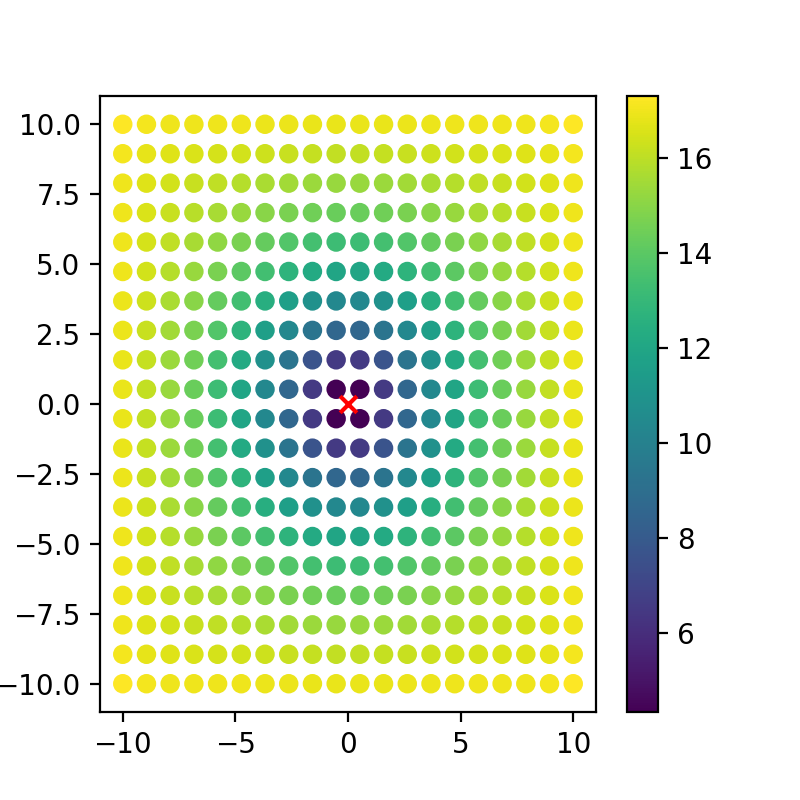

In [36]:
obj.visualise2d(lim=10, n=20)

In [47]:
lim = 
x, y = np.linspace(-lim, lim, n), np.linspace(-lim, lim, n)
xx, yy = np.meshgrid(x, y)
zz = np.zeros(xx.shape)
for j in range(n):
    for i in range(n):
        zz[j, i] = self.func(np.array([x[i], y[j]]))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
sc = ax.scatter(x=xx.ravel(), y=yy.ravel(), c=zz.ravel(), cmap='YlGnBu')
ax.set_title("function value f(x1, x2)")
ax.set_xlabel("x1 axis")
ax.set_ylabel("x2 axis")
ax.scatter(x=[self.optimal[0]], y=[self.optimal[1]], c='red', marker='x')
plt.colorbar(sc)
fig.show()

SyntaxError: invalid syntax (<ipython-input-47-c83320f8df94>, line 1)

In [16]:
def draw_ellipse(ax, mean, std):
    eigVal_sqrt = np.linalg.norm(std, ord=2, axis=(0))
    eigVec = std / eigVal_sqrt
    width, height = 2 * 3 * eigVal_sqrt
    angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
    e1 = patches.Ellipse(mean, width, height,
                         angle=-angle, linewidth=2, fill=False, zorder=2)
    ax.add_patch(e1)
    ax.scatter(mean[0], mean[1], c='black', s=15)

<IPython.core.display.Javascript object>


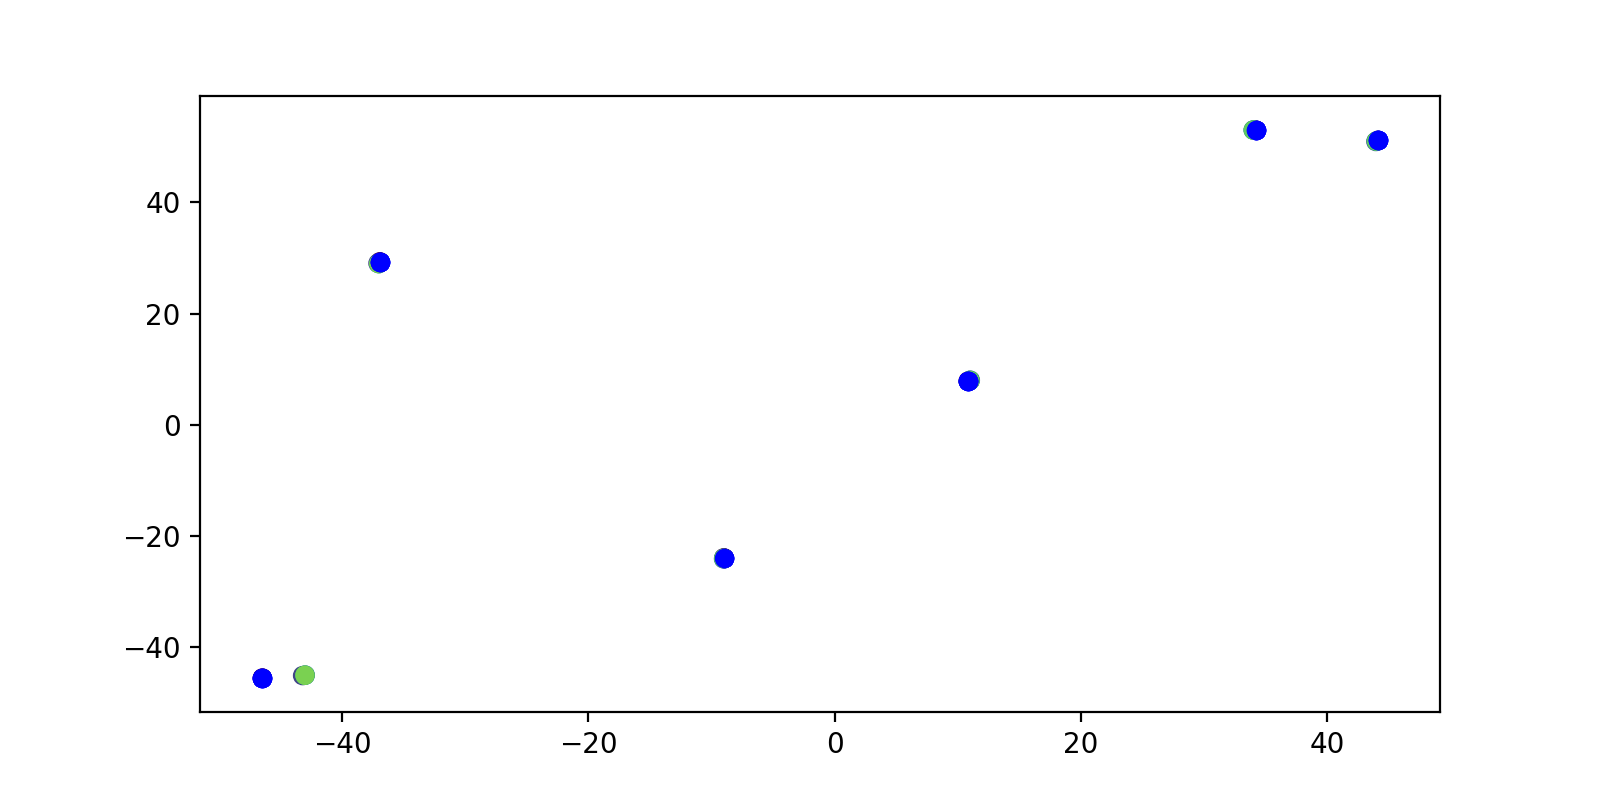

4 [10.84876992 11.0268287  10.99282688 10.99380041]
5 [-36.91463591 -37.06734186 -37.00410311 -36.9997485  -36.99995571]
4 [44.09515184 43.95398828 43.99929421 44.00003122]
5 [-46.4553501  -43.18908972 -42.97112839 -43.00075182 -42.9999582 ]
4 [34.21837297 34.00172365 33.99991606 33.99999998]
4 [-8.98694651 -9.00998823 -8.99960396 -8.99950224]


In [78]:
i =10
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)   
for j in range(6):
    norm = stats['inner'][i][j]['arg'].shape[0]
    print(norm, stats['inner'][i][j]['arg'][:,0])
    ax.scatter(stats['inner'][i][j]['arg'][:,0], stats['inner'][i][j]['arg'][:,1], c=np.arange(norm)/norm, vmin=0, vmax=1)
    ax.scatter(stats['x_adjust'][i,0,:], stats['x_adjust'][i,1,:], c="blue")

<IPython.core.display.Javascript object>


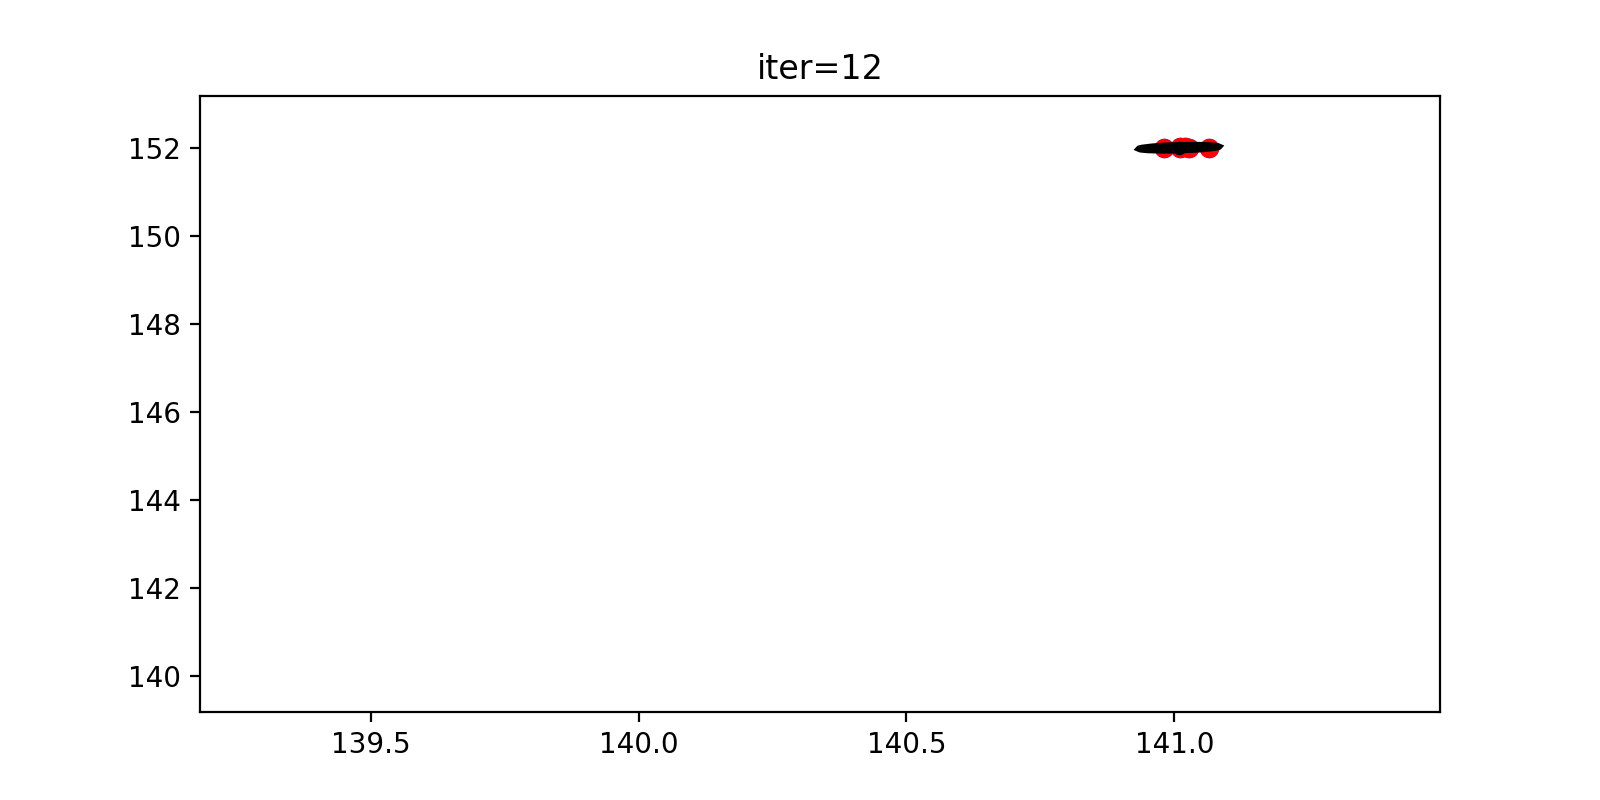

In [73]:
def setup_scatter(ax, i):
    '''
    set up the plot of CMA-ES candidates at i-th iteration
    '''
    # draw x-axis and y-axis
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draw candidates on scatter plot
    min_x = np.min(stats['arg'][:,:,0])
    min_y = np.min(stats['arg'][:,:,1])
    max_x = np.max(stats['arg'][:,:,0])
    max_y = np.max(stats['arg'][:,:,1])
    #print(min_x, max_x, min_y, max_y)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_x, max_y)
   # for j in range(6):
 #       norm = stats['inner'][i][j]['arg'].shape[0]
        #print(norm, stats['inner'][i][j]['arg'][:,0])
        #ax.scatter(stats['inner'][i][j]['arg'][:,0], stats['inner'][i][j]['arg'][:,1], c=np.arange(norm)/norm, vmin=0, vmax=1)
    ax.scatter(stats['x_adjust'][i,0,:], stats['x_adjust'][i,1,:], c="blue")
    ax.scatter(stats['x_adjust'][i,2,:], stats['x_adjust'][i,3,:], c="red")
    draw_ellipse(ax, stats['mean'][i], stats['std'][i])
    
def animate(i):
    plt.clf()
    ax = fig.add_subplot(1, 1, 1)    
    #ax = obj.visualise2d(200, 200)
    ax.set_title('iter=%d' % (i+1))
    setup_scatter(ax, i+1)
fig = plt.figure(figsize=(8,4))
ani = animation.FuncAnimation(fig, animate, frames=stats['arg'].shape[0]-1, repeat=False, interval=500)

In [44]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Huajian'), bitrate=600)

ani.save('../im.mp4', writer=writer)

<IPython.core.display.Javascript object>


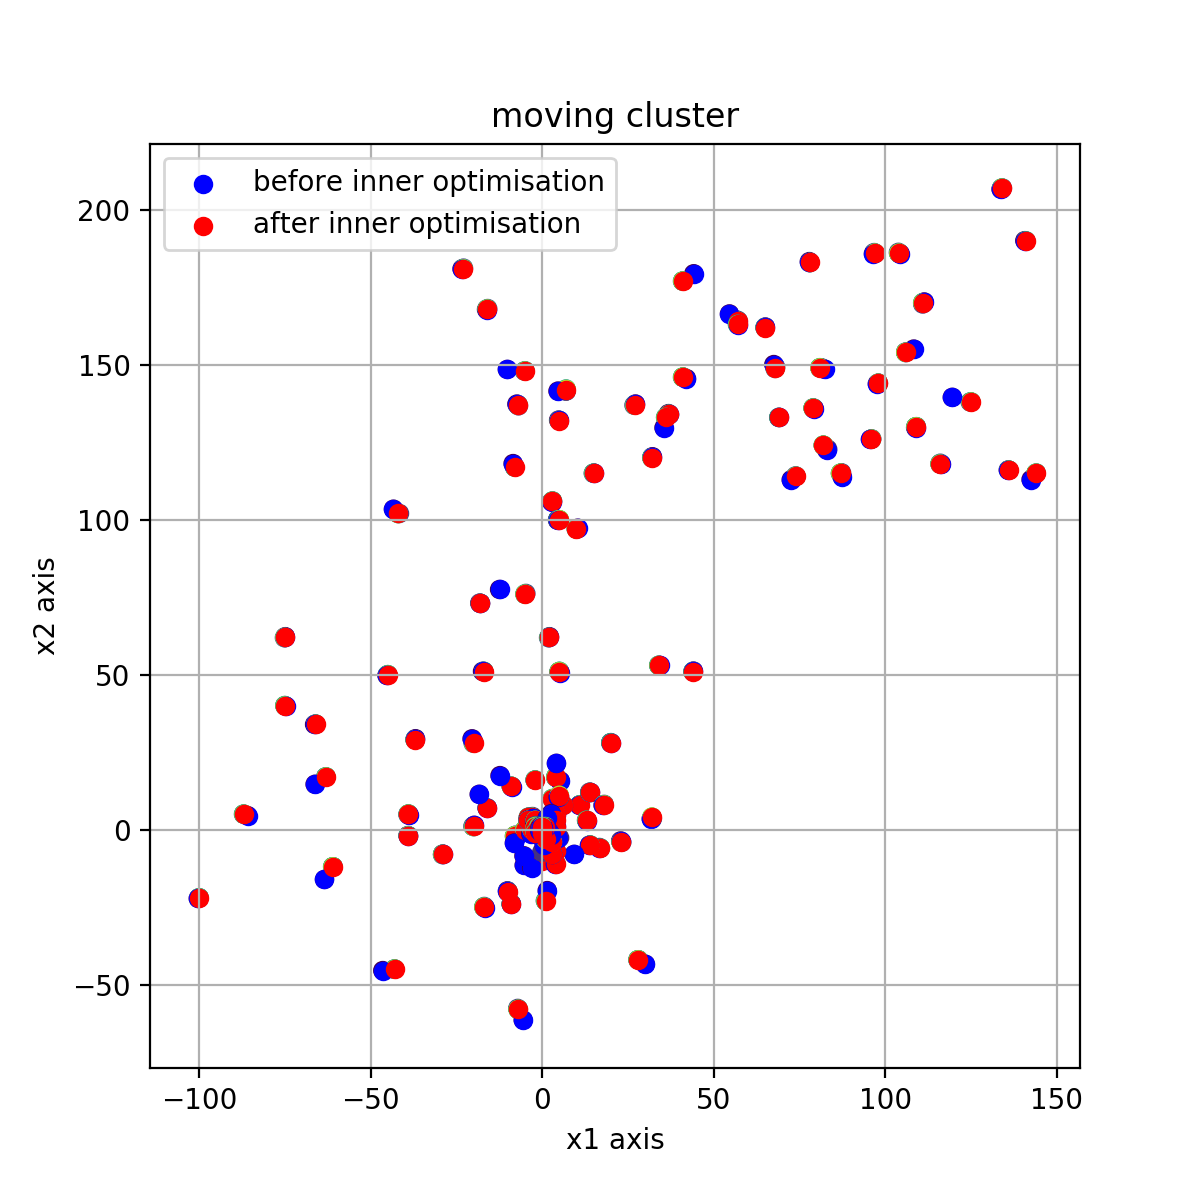

Text(0.5, 1.0, 'moving cluster')

In [33]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111);
plt.grid(True)
for i in range(stats['val'].shape[0]):
    if i == 0:
        continue
    #print(stats['x_adjust'][i,2,:])
    #print(stats['x_adjust'][i,3,:])
    for j in range(6):
        norm = stats['inner'][i][j]['arg'].shape[0]
        #print(norm, stats['inner'][i][j]['arg'][:,0])
        ax.scatter(stats['inner'][i][j]['arg'][:,0], stats['inner'][i][j]['arg'][:,1], c=np.arange(norm)/norm, vmin=0, vmax=1)
    ax.scatter(stats['x_adjust'][i,0,:], stats['x_adjust'][i,1,:], c="blue", label="before inner optimisation")
    ax.scatter(stats['x_adjust'][i,2,:], stats['x_adjust'][i,3,:], c="red", label="after inner optimisation")
    if(i == 1):
        plt.legend()
    #draw_ellipse(ax, stats['mean'][i], stats['std'][i])
plt.xlabel("x1 axis")
plt.ylabel("x2 axis")
plt.title("moving cluster")

In [22]:
stats['inner'][1]

{'status': None,
 'gradient': array([[-4.24198808,  1.13759482],
        [ 1.84064963, -2.423788  ],
        [-0.00718629, -0.00682096]]),
 'arg': array([[140.70441094, 190.04140786],
        [141.03581626, 189.95253327],
        [140.99986607, 189.99987288]]),
 'val': array([21.31066089, 20.09265463, 20.00000091]),
 'evals': 16}

In [10]:
ana = post_analysis_single(stats)

<IPython.core.display.Javascript object>


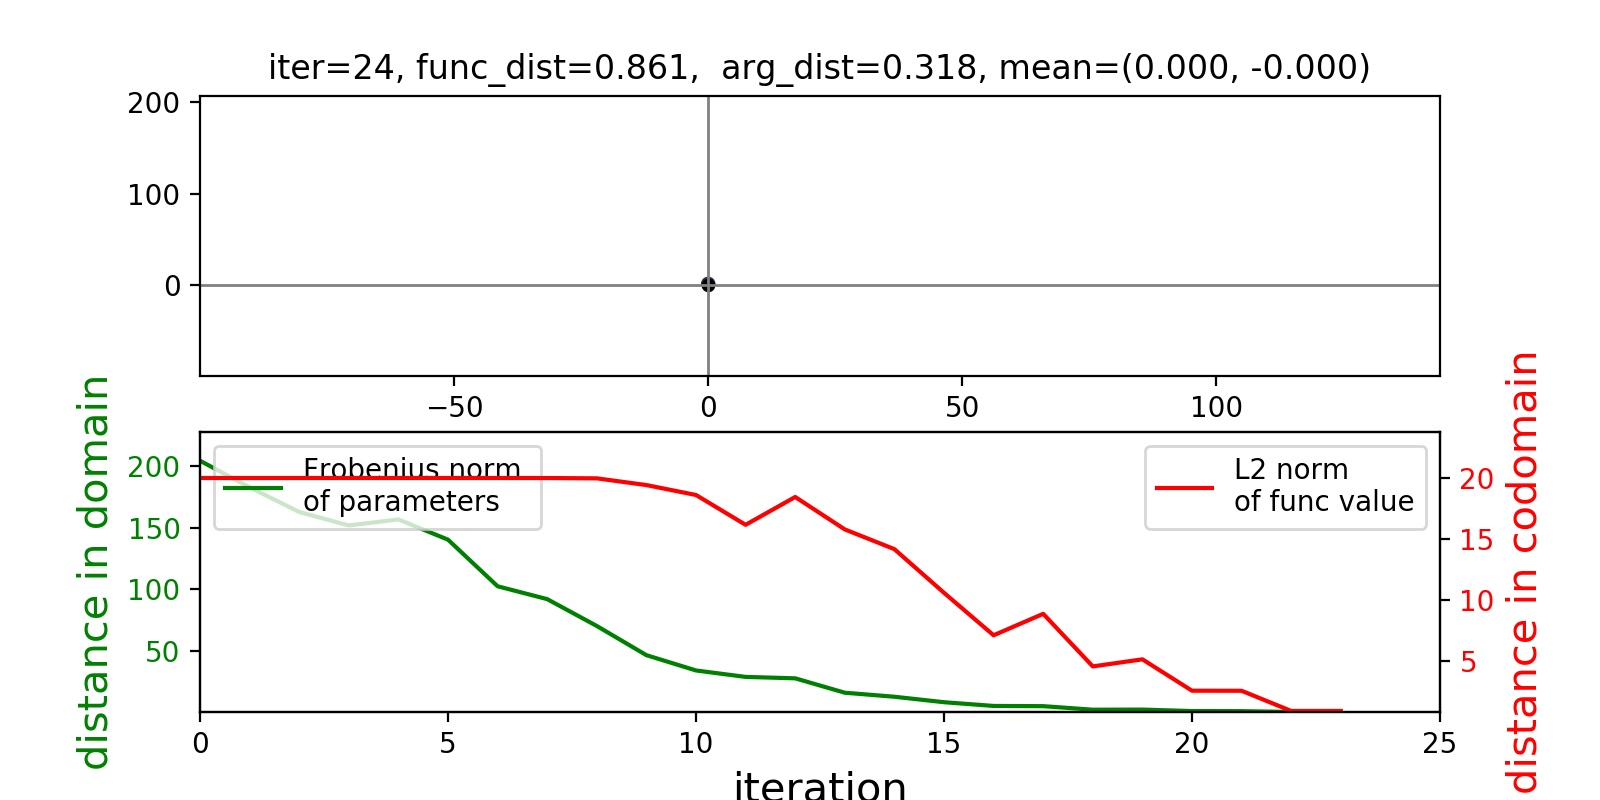

In [7]:
ana.animate_scatterplot_distance()

<IPython.core.display.Javascript object>


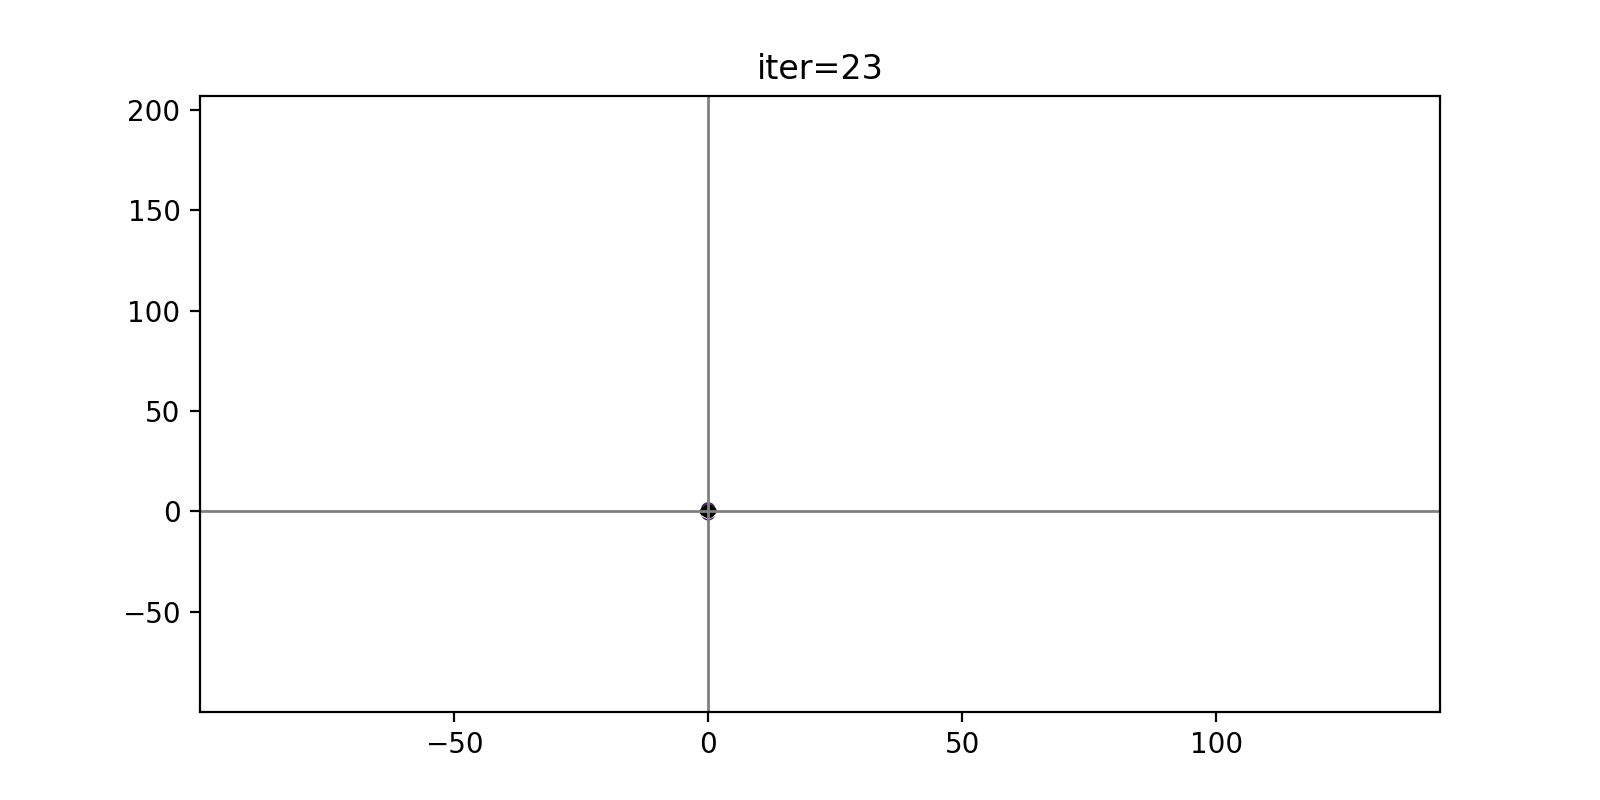

In [11]:
ana.animate_moving_cluster()

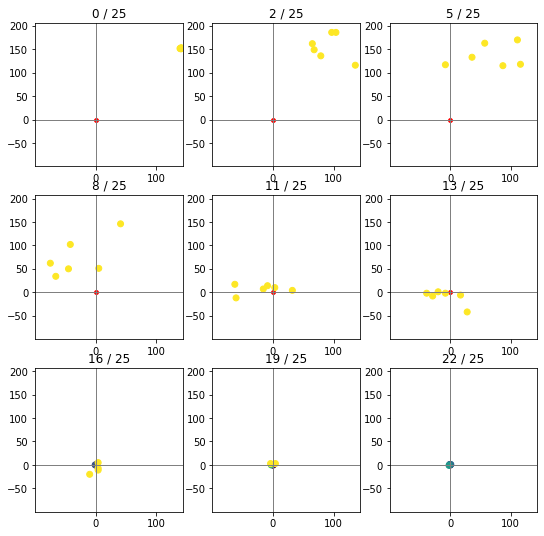

In [50]:
ana.plot_moving_cluster()

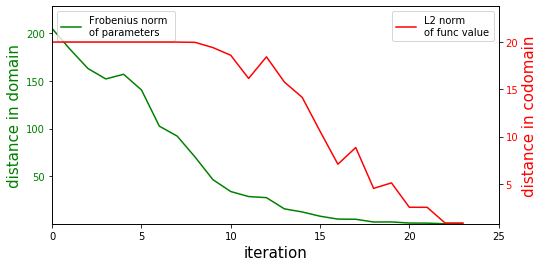

In [31]:
ana.plot_distance()

In [29]:
ana.print_evaluations_per_iteration()

iter= 0 
 [1. 1. 1. 1. 1. 1.] 

iter= 1 
 [20. 20. 20. 22. 20. 16.] 

iter= 2 
 [22. 20. 20. 18. 24. 22.] 

iter= 3 
 [22. 22. 24. 22. 20. 24.] 

iter= 4 
 [20. 22. 20. 20. 16. 20.] 

iter= 5 
 [22. 18. 22. 18. 20. 18.] 

iter= 6 
 [28. 18. 20. 22. 18. 20.] 

iter= 7 
 [18. 26. 18. 20. 22. 20.] 

iter= 8 
 [22. 20. 22. 22. 18. 20.] 

iter= 9 
 [18. 22. 18. 16. 18. 22.] 

iter= 10 
 [18. 20. 18. 20. 18. 18.] 

iter= 11 
 [14. 26. 18. 22. 20. 20.] 

iter= 12 
 [22. 20. 20. 24. 20. 22.] 

iter= 13 
 [20. 22. 20. 20. 24. 18.] 

iter= 14 
 [20. 20. 18. 18. 18. 24.] 

iter= 15 
 [24. 18. 20. 18. 24. 24.] 

iter= 16 
 [20. 20. 26. 18. 20. 36.] 

iter= 17 
 [22. 18. 22. 22. 38. 31.] 

iter= 18 
 [20. 30. 20. 18. 24. 18.] 

iter= 19 
 [18. 26. 20. 22. 33. 33.] 

iter= 20 
 [20. 20. 20. 20. 20. 29.] 

iter= 21 
 [24. 27. 26. 22. 20. 24.] 

iter= 22 
 [19. 27. 20. 22. 22. 20.] 

iter= 23 
 [26. 26. 22. 22. 21. 24.] 

iter= 24 
 [29. 24. 24. 20. 22. 26.] 



In [30]:
ana.print_mean_variance()

iter= 0 mean= [[140.743 152.21 ]] 
var=
 [[900.   0.]
 [  0. 900.]] 

iter= 1 mean= [[104.11565669 145.34967446]] 
var=
 [[1011.71345632    7.85605391]
 [   7.85605391  813.38915603]] 

iter= 2 mean= [[ 74.77231733 141.73748093]] 
var=
 [[1344.33534579   13.56848685]
 [  13.56848685  908.79643944]] 

iter= 3 mean= [[ 48.06007354 132.43835169]] 
var=
 [[1863.15371812   22.64248785]
 [  22.64248785 1091.02083455]] 

iter= 4 mean= [[ 57.27828956 122.35661891]] 
var=
 [[1381.29254202  -40.37451501]
 [ -40.37451501  845.8118387 ]] 

iter= 5 mean= [[ 11.9678509  121.39633544]] 
var=
 [[2282.75328543   64.69318992]
 [  64.69318992  918.72913283]] 

iter= 6 mean= [[  7.61616949 102.30462766]] 
var=
 [[2060.21856909  200.59499611]
 [ 200.59499611  933.25621302]] 

iter= 7 mean= [[-3.45632551 68.10890269]] 
var=
 [[2442.61836121  564.4088253 ]
 [ 564.4088253  1798.50728459]] 

iter= 8 mean= [[-14.7939916   49.38282491]] 
var=
 [[2500.55236806  800.35370858]
 [ 800.35370858 2192.3140699 ]] 

iter

In [31]:
ana.print_points_before_and_after_adjust()

iter= 0 
before
 [[140.9868351  139.18182301 140.39093766 141.03229924 141.22092422
  141.49544345]
 [151.46268182 151.74574688 150.92850812 153.1900285  152.66081813
  151.69942821]] 
after
 [[140.9868351  139.18182301 140.39093766 141.03229924 141.22092422
  141.49544345]
 [151.46268182 151.74574688 150.92850812 153.1900285  152.66081813
  151.69942821]] 

iter= 1 
before
 [[119.57043589 133.77813622  77.90051902  97.71878013 142.52843469
  140.70441094]
 [139.48048243 206.66421429 183.28868341 143.86313908 112.9606359
  190.04140786]] 
after
 [[125.00000748 133.999961    78.00001898  97.99999929 143.99992028
  140.99986607]
 [138.00000809 206.99998437 182.9999971  143.99999097 114.99987133
  189.99987288]] 

iter= 2 
before
 [[ 96.58153826  79.3040365  135.89985822  65.07112345 104.32654531
   67.54112451]
 [185.85729316 135.87183848 116.05976979 162.18404597 185.83881474
  150.06194875]] 
after
 [[ 97.00009628  79.00000198 136.00000965  64.9999679  103.9999901
   68.00004152]
 [185

In [7]:
# 1 optimiser
inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 1,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': False
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = eggholder()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 550,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

invalid value encountered in double_scalars



cost: 330.7446182005433, prob: 0.0
complete: 2 / 4 
cost: 270.62116424046513, prob: 0.1
complete: 4 / 4 
avg probility of convergence:  0.025
avg cost:  312.83334313370943
avg evals per exp:  30259.8
total time: 29.350615978240967,  time per eval:6.0622128984331045e-05

